# Exercise 06 CNN for Image Classification - Assignment

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classification model using CNN.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a CNN-based image classifier
- Train the network, save and reload the best one
- Test and evaluation

### Import libraries

In [12]:
# [TBC] complete your code here with proper comments
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from sklearn import datasets as sklearn_datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

## Task 1. Build the data pipeline

You are required to use the PyTorch built-in CIFAR10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

<span style="color:red">**[TBC]**</span> You need to:
- Use `torchvision.datasets.CIFAR10()` to load the CIFAR10 dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [13]:
# [TBC] complete your code here with proper comments

# define transformations required by the pre-trained SqueezeNet model
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit SqueezeNet input
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalization parameters for pre-trained models
])

# load CIFAR-10 dataset
train_val_ds = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [15]:
# display the dimensionality of a batch
for (X, y) in val_dl:
    print('Feature shape:', X.shape)
    print('Label shape:', y.shape)
    break

Feature shape: torch.Size([512, 3, 224, 224])
Label shape: torch.Size([512])


## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure of the network
    - You are required to use at least one convolutional layer in the network
- Specify the device used for computation
- Create an instance of the network and move it to the corresponding device

In [16]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class ImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 9, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 27, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        return self.net(x)


In [17]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [18]:
# create the neural network
model = ImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
).to(device)

## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Train the network
    - Adjust the training hyper-parameters if necessary to get a good result
- Reload the best model after training
- Plot the loss history of the training process

In [19]:
# [TBC] complete your code here with proper comments
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    # aggregate loss histories into a dictionary
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device) # move data to GPU
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device) # move data to GPU
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            # save the current model as a new minimal validation loss is achieved
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [20]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 4 #because of compuationnal power
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

In [21]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
model.load_state_dict(torch.load(saved_path))

Epoch 1: train loss = 1.732970, val loss = 1.538161, time consumed = 0:13:14
Model saved after epoch 1
Epoch 2: train loss = 1.436469, val loss = 1.551067, time consumed = 0:26:31
Epoch 3: train loss = 1.301099, val loss = 1.489291, time consumed = 0:37:37
Model saved after epoch 3
Epoch 4: train loss = 1.195809, val loss = 1.553626, time consumed = 0:47:57


<All keys matched successfully>

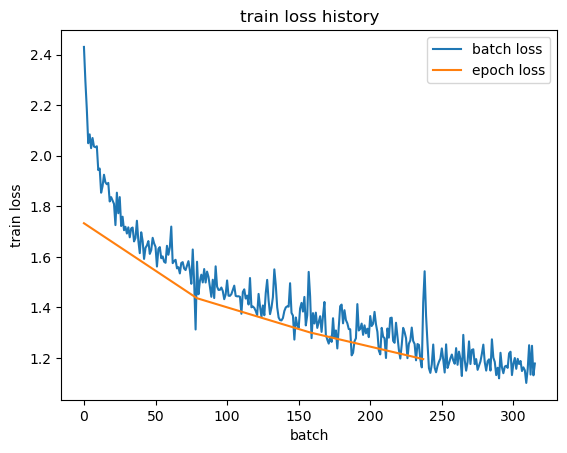

In [22]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['train_batch']))
epoch = np.arange(len(histories['train_epoch']))
batches_per_epoch = (int(len(train_ds) / batch_size + 1))
plt.plot(batch, histories['train_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['train_epoch'], '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

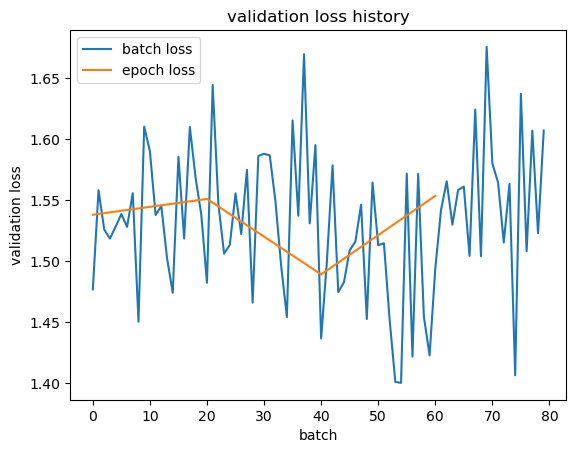

In [23]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['val_batch']))
epoch = np.arange(len(histories['val_epoch']))
batches_per_epoch = (int(len(val_ds) / batch_size + 1))
plt.plot(batch, histories['val_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['val_epoch'], '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('validation loss')
plt.legend()
plt.show()

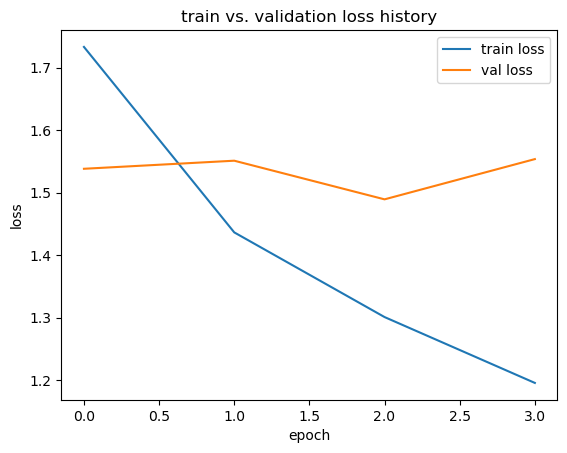

In [24]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Task 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [25]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device) # move data to GPU
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [27]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())
print(classification_report(test_label, test_pred))

test loss = 1.483196496963501
              precision    recall  f1-score   support

           0       0.50      0.64      0.56      1000
           1       0.47      0.75      0.58      1000
           2       0.38      0.43      0.40      1000
           3       0.37      0.14      0.20      1000
           4       0.47      0.29      0.36      1000
           5       0.43      0.38      0.40      1000
           6       0.39      0.78      0.52      1000
           7       0.57      0.50      0.54      1000
           8       0.65      0.57      0.61      1000
           9       0.71      0.27      0.39      1000

    accuracy                           0.47     10000
   macro avg       0.49      0.47      0.46     10000
weighted avg       0.49      0.47      0.46     10000

